# Reinforcement Learning - Deep Q Network

In [1]:
import numpy as np
import random
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
import os
import pickle

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1) 

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

# !pip install gym==0.10.8
# !pip install box2d

import gym
import pandas as pd


assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128, observation_space=4, action_space=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(observation_space, num_hidden)
        self.l2 = nn.Linear(num_hidden, action_space)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.l2(out)

        return out

In [3]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return batch

    def __len__(self):
        return len(self.memory)

In [4]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs, device):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if random.random() < self.epsilon:
            action = random.randint(0, 1)
        else:
            with torch.no_grad():
                action = torch.argmax(self.Q(torch.Tensor(obs).to(device))).item()
        return int(action)
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [5]:
def get_epsilon(it, start=1, end=0.05, length=1000):
    if it < length:
        epsilon =  - it/(1000/0.95)
    else:
        epsilon = 0.05
    return epsilon

def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def compute_q_vals(Q, states, actions, device):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    QValues = Q(states.to(device))[torch.arange(len(actions)).to(device), actions.squeeze().to(device)]
    return QValues.unsqueeze(dim=1)

def compute_targets(Q, rewards, next_states, dones, discount_factor, target_net, device):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    maxQs = torch.max(target_net(next_states.to(device)), 1).values
    if isinstance(dones, torch.BoolTensor):
        targets = rewards.to(device) + discount_factor * maxQs.unsqueeze(dim=1).to(device) * (~dones).to(device)
    else:
        targets = rewards.to(device) + discount_factor * maxQs.unsqueeze(dim=1).to(device) * (1 - dones).to(device)
    return targets
    
def train(Q, memory, optimizer, batch_size, discount_factor, target_net, device):
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action, device)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor, target_net, device)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [6]:

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, device, rendering_criterium=999999, use_target_net=True):
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    if use_target_net:
        TARGET_UPDATE = 10
        target_net = copy.deepcopy(Q)
        target_net.eval()
    else:
        target_net = Q
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_scores = []  #
    weights = []
    rendering = False
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        
        score = 0
        while True:
            policy.set_epsilon(get_epsilon(global_steps))
            action = policy.sample_action(state, device)
            state_next, reward, done, _ = env.step(action)                

            loss = train(Q, memory, optimizer, batch_size, discount_factor, target_net, device)

            global_steps += 1
            score += reward

            if rendering:
                env.render()
                time.sleep(0.05)

            memory.push((state, action, reward, state_next, done))
            state = state_next

            if done:
                # if i % 10 == 0:
                    # print("{2} Episode {0} finished with a score o`f {1}"
                        #   .format(i, score, '\033[99m'))

                episode_scores.append(score)

                # os.makedirs("weights", exist_ok=True)
                # torch.save(Q.state_dict(), 'Q_net_weights_episode_{i}.pth')

                weights.append(copy.deepcopy(Q).state_dict().copy())

                if score > rendering_criterium:
                    rendering = True
                else:
                    rendering = False
                break
                
            if use_target_net and (i % TARGET_UPDATE == 0):
                target_net.load_state_dict(Q.state_dict())
            
        env.close()

    return episode_scores, weights

In [7]:
########### Could try Gym Envs ###################

# https://github.com/paulhendricks/gym-inventory
# gym-inventory is a single agent domain featuring discrete state and action spaces that an AI agent might encounter in inventory control problems.

# gym-maze: 2D maze environment
# A simple 2D maze environment where an agent finds its way from the start position to the goal.
# Learn more here: https://github.com/tuzzer/gym-maze/

# Works with pixels, so not really suited for us
# gym-minigrid: Minimalistic Gridworld Environment
# A minimalistic gridworld environment. Seeks to minimize software dependencies, be easy to extend and deliver good performance for faster training.
# Learn more here: https://github.com/maximecb/gym-minigrid

# gym-anytrading: Environments for trading markets
# AnyTrading is a collection of OpenAI Gym environments for reinforcement learning-based trading algorithms with a great focus on simplicity, flexibility, and comprehensiveness.
# https://github.com/AminHP/gym-anytrading

# Actually continious, could work when discretely controlled, requires little hack. Seems too simple tho.
# new_env = gym.envs.make("CarRacing-v0")

############# NOTES #####################

# w/ experience replay, w/o target network:
# Converging:

# CartPole-v1
# Acrobot-v1
# LunarLander-v2

# not converging: 
# MountainCar-v0, tested up to 5k episodes < too sparse rewards? 

# w/ experience replay, w/ target network:
# Converging:

# CartPole-v1
# Acrobot-v1
# LunarLander-v2

# not converging: 
# MountainCar-v0, tested up to 5k episodes < too sparse rewards? 


In [8]:
# Target net doesn't seem to have a clear positive effect
# W/o experience replay (memory size =1), very bad results

In [9]:
cuda_ = "cuda:0"
device = torch.device(cuda_ if torch.cuda.is_available() else "cpu")

seed = 42
results = []
all_episode_weights = []

print(device)

test_envs = ["CartPole-v1", "Acrobot-v1", "LunarLander-v2", "MountainCar-v0" ]
runs_per_setup = 25
num_episodes = 1500
discount_factor = 0.8


# for i in range(runs_per_setup):                      
#     for memory_size in [10000]:                    # 3
#         for learn_rate in [1e-2, 1e-3, 1e-4, 1e-5]:          # 4
#             for num_hidden in [512]:           # 4
#                 for env in test_envs:                       # 4
#                     for use_target in [True, False]:        # 2
#                                                             # = 384 runs 

# Jan: [mem_size: 10.000, use_target: True]
# Longxiang: [mem_size: 10.000, use_target: False]
# Alex: [mem_size: 64, use_target: True]
# Fabrizio: [mem_size: 64, use_target: False]

for i in range(runs_per_setup):                      
    for memory_size in [64]:                    # 2
        for learn_rate in [1e-2, 1e-3, 1e-4]:          # 3
            for num_hidden in [128, 256, 512]:           # 3
                for env in test_envs:                       # 4
                    for use_target in [True]:        # 2
                                                            # = 144 runs
                        if memory_size < 64:
                            batch_size = memory_size
                        else:
                            batch_size = 64

                        seed += 1
                        new_env = gym.envs.make(env)
                        memory = ReplayMemory(memory_size)

                        random.seed(seed)
                        torch.manual_seed(seed)
                        new_env.seed(seed)

                        setup = {"env":env, "batch_size":batch_size, "use_target":use_target, "num_hidden":num_hidden, "learn_rate":learn_rate, "memory_size":memory_size, "discount_factor":discount_factor, "run":i}

                        try:
                            # Continious obs space
                            Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.low.shape[0], action_space=new_env.action_space.n).to(device)
                            obs_space = new_env.observation_space.low.shape[0]
                        except:
                            # Discrete obs space
                            Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.n, action_space=new_env.action_space.n).to(device)
                            obs_space = new_env.observation_space.n

                        policy = EpsilonGreedyPolicy(Q_net, 0.05)
                        episode_scores, episode_weights = run_episodes(train, Q_net, policy, memory, new_env, num_episodes, batch_size, discount_factor, learn_rate, device, use_target_net=use_target)        

                        # # L2 norm calculation
                        l2_norms=[]
                        for weights in episode_weights:
                            all_weights = []
                            for layer in weights.keys():
                                all_weights.append(weights[layer].flatten())
                            all_weights = torch.cat(all_weights, dim=0)
                            l2_norms.append(torch.norm(((all_weights)), 2, -1))

                        # # Save results
                        results.append({**setup, **{"scores":episode_scores, "l2_norms":l2_norms}})
                        df = pd.DataFrame(results)
                        df.to_csv("results.csv")

                        # save network weight history
                        all_episode_weights.append({**setup, **{"episode_network_weights":episode_weights}})
                        with open('all_runs_weight_histoires.pkl', 'wb') as handle:
                            pickle.dump(all_episode_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

                        # plt.plot(l2_norms)
                        # plt.show()



/opt/anaconda3/envs/rl1/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
  0%|          | 0/1500 [00:00<?, ?it/s]

cpu


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


  0%|          | 0/1500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 45%|████▌     | 681/1500 [16:12<2:09:27,  9.48s/it]

KeyboardInterrupt: 

In [ ]:
with open('all_runs_weight_histoires.pkl', 'rb') as handle:
    weight_dict = pickle.load(handle)

weight_dict[0]["episode_network_weights"][0].keys()


\begin{tabular}{lllrrrr}
\toprule
{} &             env &  use\_target &  memory\_size &  learn\_rate &  num\_hidden &  convergence \\
\midrule
36 &     CartPole-v1 &        True &           64 &        0.01 &         128 &          101 \\
37 &      Acrobot-v1 &        True &           64 &        0.01 &         128 &          103 \\
38 &  LunarLander-v2 &        True &           64 &        0.01 &         128 &          140 \\
39 &  MountainCar-v0 &        True &           64 &        0.01 &         128 &          101 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllrrrr}
\toprule
{} &             env &  use\_target &  memory\_size &  learn\_rate &  num\_hidden &  convergence \\
\midrule
36 &     CartPole-v1 &        True &        10000 &        0.01 &         128 &          101 \\
37 &      Acrobot-v1 &        True &        10000 &        0.01 &         128 &          196 \\
38 &  LunarLander-v2 &        True &        10000 &        0.01 &         128 &          105 \\
39 &  MountainC

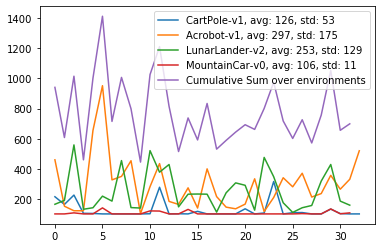

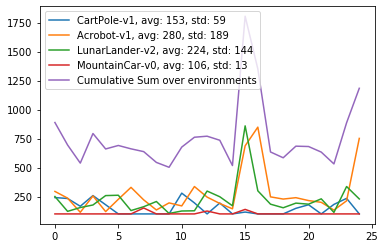

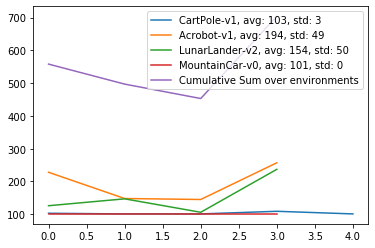

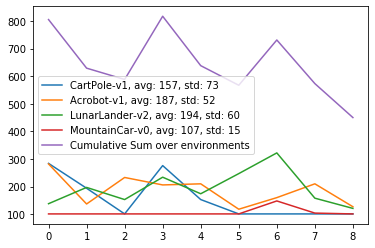

In [242]:
def read_results(filename):
    results = pd.read_csv(filename)
    results.scores = results.apply(lambda x: [float(score.strip(' []')) for score in x.scores.split(',')], 1)
    return results

def convergence_check(row, delta, average_range):
    scores = row.scores
    
    for i in range(average_range,len(scores)-average_range):
        left_window = scores[(i-average_range):i]
        right_window = scores[(i+1):(i+1+average_range)]
        
        if np.abs(np.average(left_window) - np.average(right_window)) < delta:
            return (i+1+average_range)
    return -1

def get_convergence(tenv_res, convergence_check, delta, average_range, axis=1):
    return tenv_res.apply(lambda x: convergence_check(x, delta, average_range), axis )

def title_format(mem_params, target_net):
    target_net_string = ""
    if target_net:
        target_net_string = "_target_network_true"
    mem_params = str(mem_params)
    return"convergence_memory_size_{}{}.png".format(mem_params,target_net_string)


def plot_results(filename, mem_params, target_net, test_envs=test_envs, delta=0.5, average_range=50):
    results = read_results(filename)
    results['convergence'] = get_convergence(results, convergence_check, delta, average_range)
    
    plt.figure()
    sum_len = len(results[results.env==test_envs[-1]])
    cum_sum = np.zeros(sum_len)
    for tenv in test_envs:
        tenv_res = results[results.env == tenv]
        
        # calculate cumulative sum
        convergence = tenv_res.convergence.tolist()
        if len(convergence) == sum_len:
            cum_sum += convergence
        else:
            cum_sum += convergence[:-1]

        idx = np.argmin(cum_sum)
        minimum = tenv_res.iloc[idx, 0]
        
        label = "{}, avg: {}, std: {}".format(tenv, round(np.average(convergence)), round(np.std(convergence)))
        plt.plot(convergence, label=label)


    print(results.iloc[(minimum-3):minimum+1, :][["env", "use_target", "memory_size", "learn_rate", "num_hidden", "convergence"]].to_latex())
    plt.plot(cum_sum, label="Cumulative Sum over environments")
    title = title_format(mem_params, target_net)
#     plt.title(title)
    plt.legend()
    plt.savefig(title)
    

test_envs = ["CartPole-v1", "Acrobot-v1", "LunarLander-v2", "MountainCar-v0" ]
plot_results("results_alex.csv", 64, True)
plot_results("results_jan_2.csv", 10000, True)
plot_results("results_fabrizio_2.csv", 64, False)
plot_results("results_benjamin.csv", 10000, False)